# Inventory Management and Demand Forecasting

In [121]:
import pandas as pd #Importing Libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [74]:
data=pd.read_csv(r"C:\Users\DC\Downloads\data.csv",encoding='ISO-8859-1') #Loading Data

In [75]:
data.head() #Viewing Data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Preprocessing

In [76]:
print(data.isnull().sum()) # Check for missing values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [77]:
data.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice'], inplace=True) #Handle missing values

In [78]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M') #Convert 'InvoiceDate' to datetime format

In [79]:
data = data[~data['InvoiceNo'].str.startswith('C')] #Remove cancellations (where 'InvoiceNo' starts with 'C')

In [80]:
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)] #Remove negative quantities and prices (outliers)

In [81]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## EDA

In [57]:
sns.set(style="whitegrid") # Set the plot style

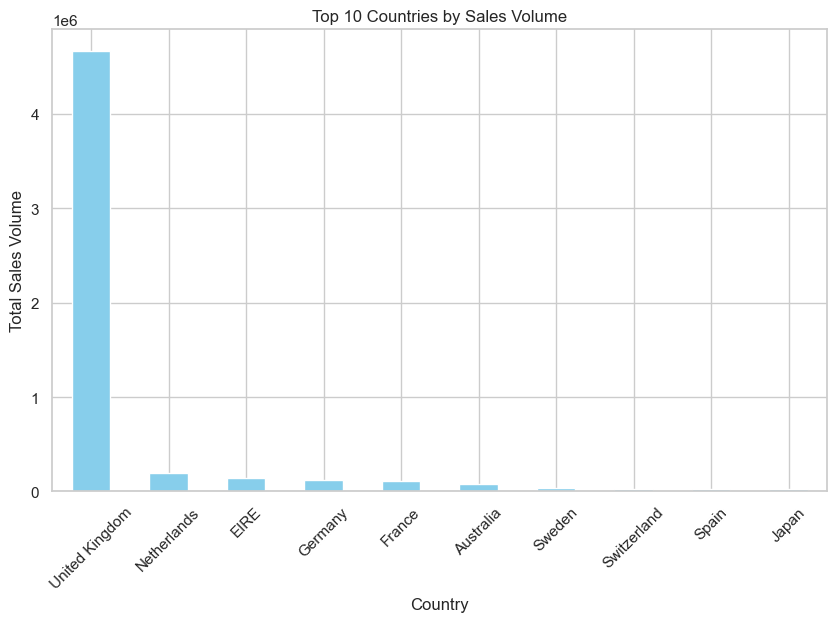

In [58]:
country_sales = data.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(10) #Sales Distribution by Country
plt.figure(figsize=(10,6))
country_sales.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Sales Volume')
plt.xlabel('Country')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.show()

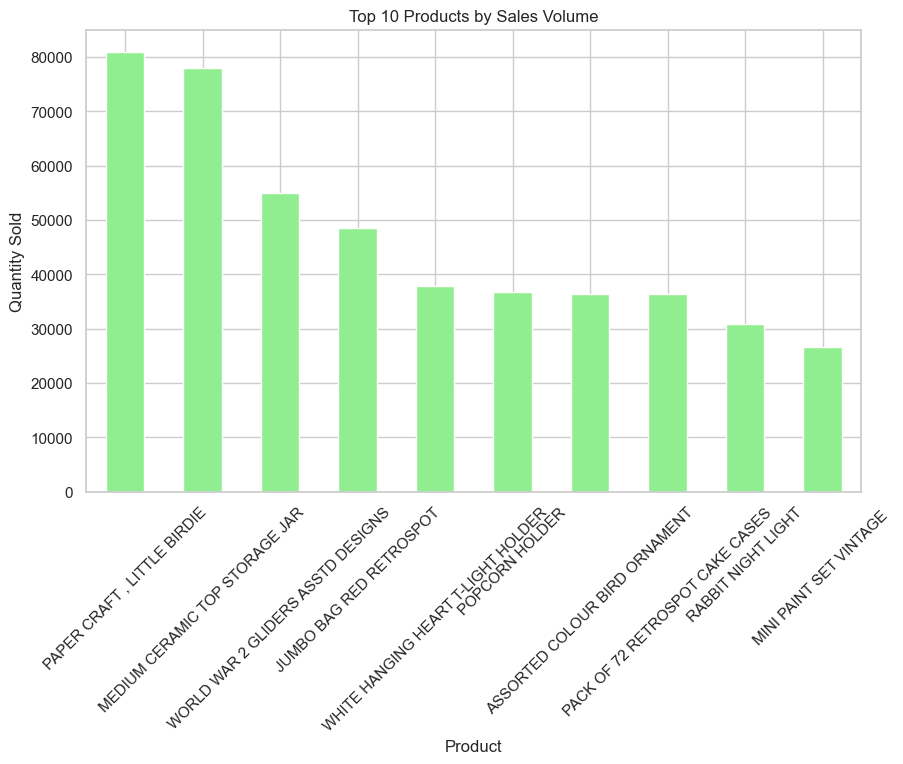

In [59]:
top_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10) #Top 10 Products by Quantity Sold
plt.figure(figsize=(10,6))
top_products.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Products by Sales Volume')
plt.xlabel('Product')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

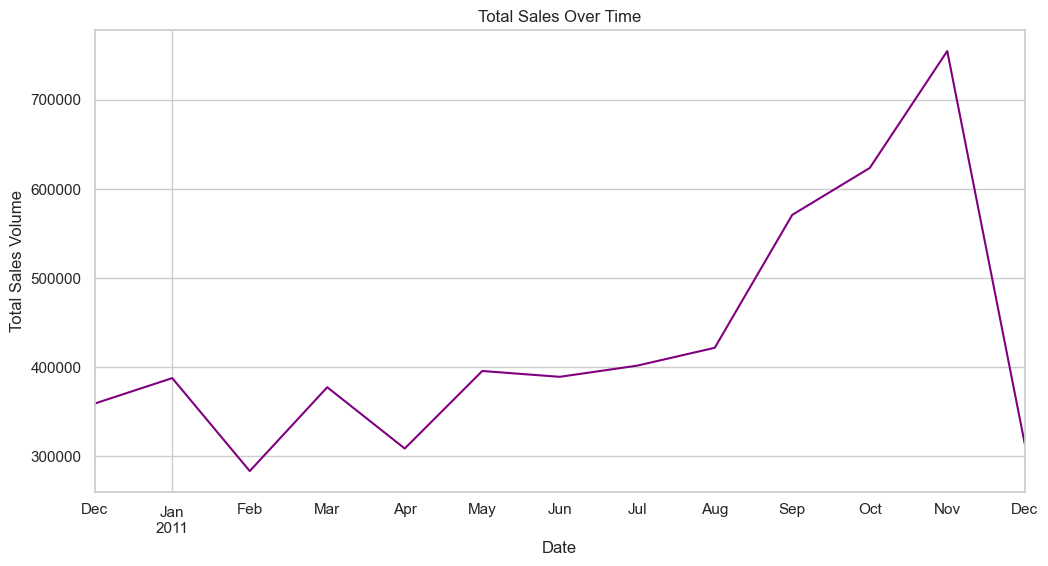

In [60]:
data['Month'] = data['InvoiceDate'].dt.to_period('M') #Total Sales Over Time (Time Series Plot)
monthly_sales = data.groupby('Month')['Quantity'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', color='purple')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Volume')
plt.show()

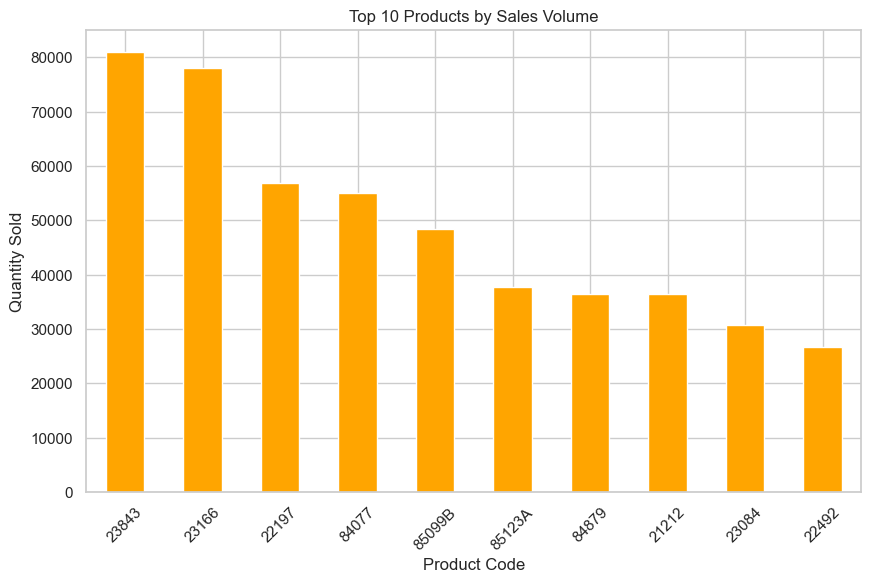

In [61]:
product_sales = data.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10) #Sales Distribution by Product
plt.figure(figsize=(10,6))
product_sales.plot(kind='bar', color='orange')
plt.title('Top 10 Products by Sales Volume')
plt.xlabel('Product Code')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

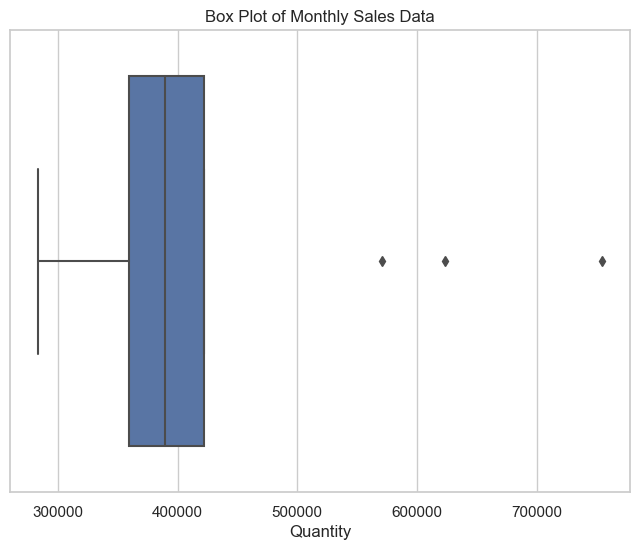

In [104]:
plt.figure(figsize=(8, 6)) # Visualizing the data using a box plot to detect outliers
sns.boxplot(x=monthly_sales)
plt.title('Box Plot of Monthly Sales Data')
plt.show()


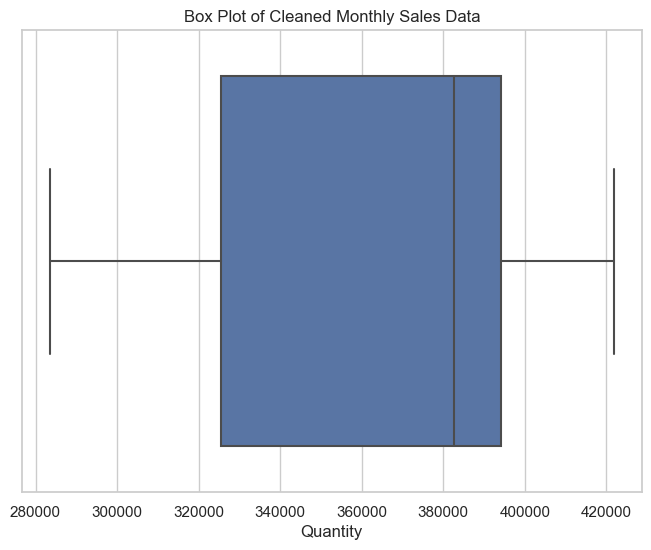

In [103]:
Q1 = monthly_sales.quantile(0.25) # Calculate the IQR
Q3 = monthly_sales.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR # Define the outlier threshold (1.5 * IQR method)
upper_bound = Q3 + 1.5 * IQR

cleaned_sales = monthly_sales[(monthly_sales >= lower_bound) & (monthly_sales <= upper_bound)] # Remove outliers

plt.figure(figsize=(8, 6)) # Visualize the cleaned sales data
sns.boxplot(x=cleaned_sales)
plt.title('Box Plot of Cleaned Monthly Sales Data')
plt.show()


## Model Building

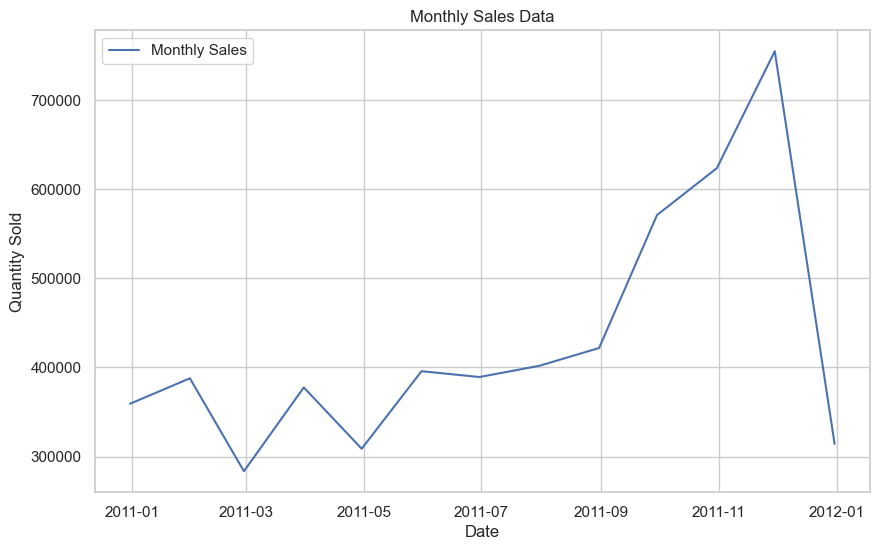

In [105]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) # Resample the data by month and sum the 'Quantity'
cleaned_sales = data.resample('M', on='InvoiceDate')['Quantity'].sum()

plt.figure(figsize=(10,6)) # Plot the resampled data to visualize the trend
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()


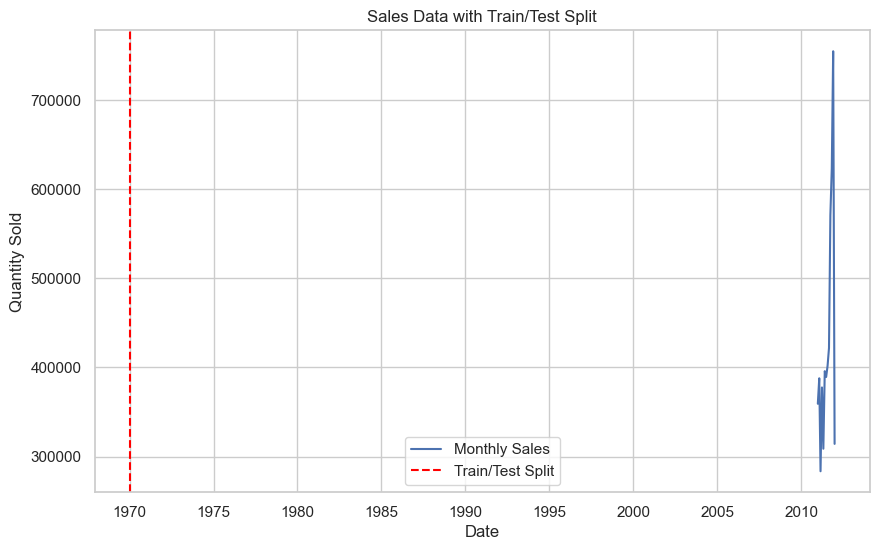

In [86]:
train_size = int(len(monthly_sales) * 0.8) # Set the train size 
train_data = monthly_sales[:train_size]
test_data = monthly_sales[train_size:]

plt.figure(figsize=(10,6)) # Visualize the train-test split
plt.plot(monthly_sales, label='Monthly Sales')
plt.axvline(x=train_size, color='red', linestyle='--', label='Train/Test Split')
plt.title('Sales Data with Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()


In [116]:
# Fit the ARIMA model automatically
model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=288.180, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=261.367, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=285.523, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=261.934, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=257.839, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=256.270, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=258.816, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=296.168, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.665 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:             

In [117]:
forecast_steps = len(test_data) # Forecast the future sales (for the test set)
forecast = model.predict(n_periods=forecast_steps)

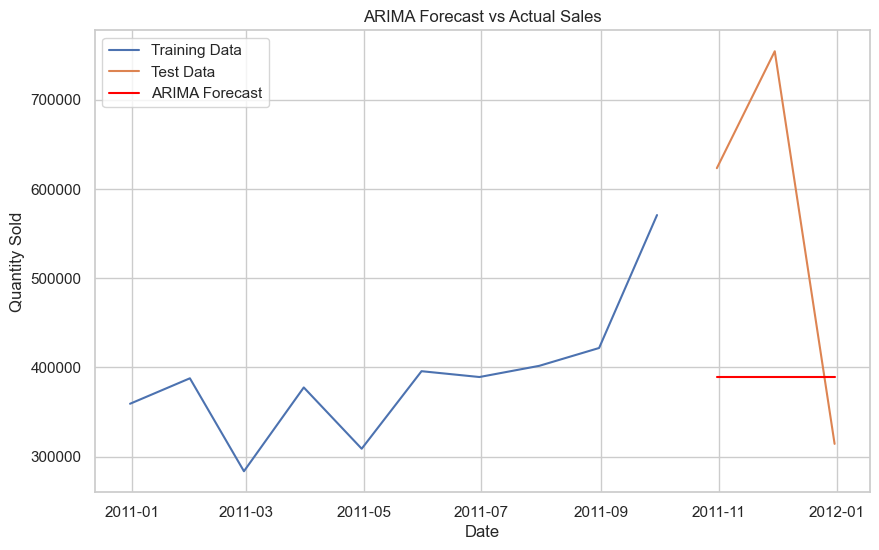

In [118]:
forecast_index = test_data.index
forecast_series = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(10,6)) # Plot the forecast
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast_series, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

## Model Evaluation

In [119]:
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 64491641314.0
Mean Absolute Error (MAE): 224679.33333333334
